In [49]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [65]:
def imwrite_unicode(path: str | Path, img: np.ndarray) -> bool:
    path = str(path)
    ext = os.path.splitext(path)[1]
    ok, buf = cv2.imencode(ext, img)
    if not ok:
        return False
    with open(path, "wb") as f:
        f.write(buf.tobytes())
    return True


def imread_unicode(path: str | Path, flags=cv2.IMREAD_GRAYSCALE) -> np.ndarray | None:
    path = str(path)
    try:
        with open(path, "rb") as f:
            data = f.read()
        arr = np.frombuffer(data, np.uint8)
        img = cv2.imdecode(arr, flags)
        return img
    except Exception as e:
        print("[imread_unicode ERROR]", e, "->", path)
        return None


In [67]:
def decompose_hangul(ch: str):
    code = ord(ch)
    if not (0xAC00 <= code <= 0xD7A3):
        raise ValueError("한글 음절만 지원합니다")

    s = code - 0xAC00
    cho = s // (21 * 28)
    jung = (s % (21 * 28)) // 28
    jong = s % 28
    return cho, jung, jong


HORIZ = {0, 1, 2, 3, 4, 5, 6, 7, 20}  
VERT  = {8, 12, 13, 17, 18}           
MIX   = {9,10,11,14,15,16,19}   

JUNG_HORIZ = {0, 1, 2, 3, 4, 5, 6, 7, 20}  
JUNG_VERT  = {8, 12, 13, 17, 18}           
JUNG_MIX   = {9,10,11,14,15,16,19}            


def vowel_type(jung_idx: int) -> str:
    if jung_idx in JUNG_HORIZ:
        return "horiz"
    if jung_idx in JUNG_VERT:
        return "vert"
    if jung_idx in JUNG_MIX:
        return "mix"
    raise ValueError("Unknown jung index")


In [69]:
def load_mask(path: Path) -> np.ndarray:
    img = imread_unicode(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    return img

In [55]:
def compose_hangul(
    ch: str,
    root_dir: str | Path,
):
    root_dir = Path(root_dir)

    cho, jung, jong = decompose_hangul(ch)
    vtype = vowel_type(jung)
    has_jong = jong != 0

    base = "jong" if has_jong else "nojong"
    folder = root_dir / base / vtype

    cho_path = folder / "chosung" / f"{cho}.png"
    jung_path = folder / "jungsung" / f"{jung}.png"

    masks = []
    masks.append(load_mask(cho_path))
    masks.append(load_mask(jung_path))

    if has_jong:
        jong_path = folder / "jongsung" / f"{jong}.png"
        masks.append(load_mask(jong_path))

    composed = np.zeros_like(masks[0])
    for m in masks:
        composed = np.maximum(composed, m)

    return composed


In [57]:
def show_composed(mask: np.ndarray, title: str = ""):
    vis = (mask > 0).astype(np.uint8) * 255

    plt.figure(figsize=(4, 4))
    plt.imshow(vis, cmap="gray")
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


C:\Users\SehoonChoi\.conda\envs\craft\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44495 (\N{HANGUL SYLLABLE GWILH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


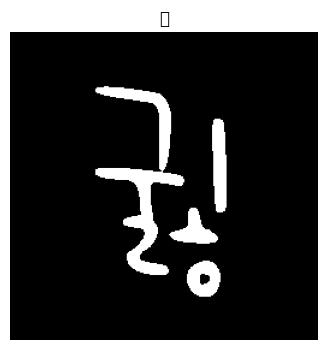

In [81]:
DATA_ROOT = Path(r"D:\Study\학교강의\4학년2학기\캡스톤\Baram_Handwritting_Analysis\hangul_dataset\korean_sample_jamo")  

test_char = "귏"   

mask = compose_hangul(test_char, DATA_ROOT)
show_composed(mask, title=test_char)
